In [75]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [76]:
data_train = load_dataset("wmt16", "de-en", split="train[:50000]")
data_val = load_dataset("wmt16", "de-en", split="validation")

In [78]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = item["translation"]["de"]
        target_text = item["translation"]["en"]

        input_ids = self.tokenizer.encode(input_text, padding='max_length', max_length=128, return_tensors='pt', truncation=True)
        target_ids = self.tokenizer.encode(target_text, padding='max_length', max_length=128, return_tensors='pt', truncation=True)

        return {"input_ids": input_ids, "labels": target_ids}
    
    def evaluate(self, model, dataloader):
        model.eval()
        references = []
        translations = []
        for batch in dataloader:
            input_ids = batch["input_ids"].squeeze(1).to(device)
            labels = batch["labels"].squeeze(1).to(device)
            outputs = model.generate(input_ids=input_ids, max_length=128, num_beams=4, early_stopping=True)
            translated_sentences = [self.tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            references.extend([self.tokenizer.decode(label, skip_special_tokens=True) for label in labels])
            translations.extend(translated_sentences)
        return references, translations

train_dataset = TranslationDataset(data_train)
val_dataset = TranslationDataset(data_val)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [79]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [80]:
config = T5Config.from_pretrained("google-t5/t5-small")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small", config=config)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [82]:
def train(model, optimizer, train_loader, val_loader, num_epochs=2):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            input_ids = batch["input_ids"].squeeze(1).to(device)
            labels = batch["labels"].squeeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].squeeze(1).to(device)
                labels = batch["labels"].squeeze(1).to(device)

                outputs = model(input_ids=input_ids, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    return train_losses, val_losses


In [83]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [84]:
train_losses, val_losses = train(model, optimizer, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Train Loss: 0.5484682945108413, Val Loss: 0.45786750141312094
Epoch 2/5, Train Loss: 0.4693308516407013, Val Loss: 0.45879064461983304
Epoch 3/5, Train Loss: 0.43309318811774256, Val Loss: 0.4659148371394943
Epoch 4/5, Train Loss: 0.40687132927298547, Val Loss: 0.46678939905455885
Epoch 5/5, Train Loss: 0.386150750439167, Val Loss: 0.47581008279367404


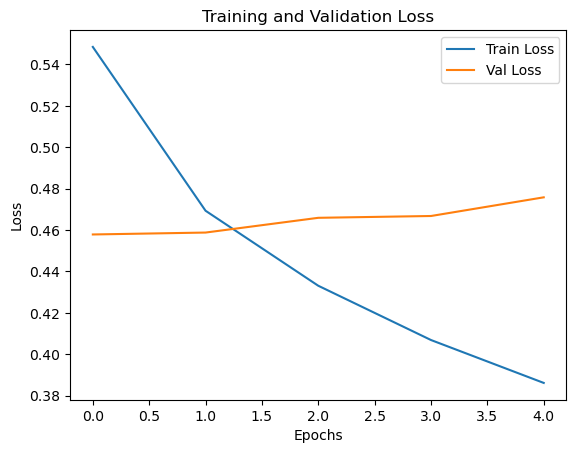

In [86]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [87]:
# Save the trained model
torch.save(model.state_dict(), 'model_2C_ger-eng.pt')

In [88]:
# Load the saved model
loaded_model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")
loaded_model.load_state_dict(torch.load('model_2C_ger-eng.pt'))
loaded_model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [89]:
from datasets import load_metric

# Load evaluation metrics
bleu_metric = load_metric("sacrebleu")
meteor_metric = load_metric("meteor")
bert_metric = load_metric("bertscore")

# Define a function to compute evaluation metrics
def compute_metrics(references, translations):
    #bleu_score = bleu_metric.compute(predictions=translations, references=references)
    meteor_score = meteor_metric.compute(predictions=translations, references=references)
    bert_score = bert_metric.compute(predictions=translations, references=references, lang="de" )
    precision = bert_score["f1"]
    avg = sum(precision) / len(precision)
    
    #bert_score_mean = sum(score['f1'] for score in bert_score) / len(bert_score)
    
    return {"meteor": meteor_score['meteor'], "bert_score": avg}

/home/deb/.local/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/deb/.local/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load thi

In [90]:
val_references, val_translations = val_dataset.evaluate(loaded_model, val_loader)
data_test = load_dataset("wmt16","de-en", split="test")
test_dataset = TranslationDataset(data_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
test_references, test_translations = test_dataset.evaluate(loaded_model, test_loader)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [91]:
print(val_translations[:5])
print(val_references[:5])

['The Prime Minister of India and Japan met in Tokio.', "India' s new Prime Minister Narendra Modi returns to his first important visit to foreign affairs since his election victory in May in his Japanese counterpart, Shinzo Abe, in Toko to discuss economic and security relations.", "Mr Modi is on a five-month trip to Japan to consolidate economic relations with the world' s third largest economic position.", 'Plans for closer cooperation on nuclear technology are top of the agenda.', 'According to reports, India also hopes for a Treaty for the defence cooperation between the two nations.']
['India and Japan prime ministers meet in Tokyo', "India's new prime minister, Narendra Modi, is meeting his Japanese counterpart, Shinzo Abe, in Tokyo to discuss economic and security ties, on his first major foreign visit since winning May's election.", 'Mr Modi is on a five-day trip to Japan to strengthen economic ties with the third largest economy in the world.', 'High on the agenda are plans f

In [92]:
val_metrics = compute_metrics(val_references, val_translations)
test_metrics = compute_metrics(test_references, test_translations)

In [93]:
#print("Validation BLEU Score:", val_metrics['bleu'])
print("Validation METEOR Score:", val_metrics['meteor'])
print("Validation BERT Score:", val_metrics['bert_score'])

#print("Test BLEU Score:", test_metrics['bleu'])
print("Test METEOR Score:", test_metrics['meteor'])
print("Test BERT Score:", test_metrics['bert_score'])

Validation METEOR Score: 0.491024051765557
Validation BERT Score: 0.8323953468137867
Test METEOR Score: 0.5330110965482197
Test BERT Score: 0.8418207255829648


In [94]:
bleu_val_ref = [[x] for x in val_references]
bleu_test_ref = [[x] for x in test_references]

In [95]:
import evaluate
bleu = evaluate.load('bleu')

In [96]:
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=1)
print("Validation BLEU-1 Score:", bleu_score)
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=2)
print("Validation BLEU-2 Score:", bleu_score)
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=3)
print("Validation BLEU-3 Score:", bleu_score)
bleu_score = bleu.compute(predictions=val_translations, references=bleu_val_ref, max_order=4)
print("Validation BLEU-4 Score:", bleu_score)
print("\n")
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 1)
print("Test BLEU-1 Score:", bleu_score)
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 2)
print("Test BLEU-2 Score:", bleu_score)
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 3)
print("Test BLEU-3 Score:", bleu_score)
bleu_score = bleu.compute(predictions=test_translations, references=bleu_test_ref, max_order = 4)
print("Test BLEU-4 Score:", bleu_score)

Validation BLEU-1 Score: {'bleu': 0.5091697164237083, 'precisions': [0.5091697164237083], 'brevity_penalty': 1.0, 'length_ratio': 1.0532991644413816, 'translation_length': 48911, 'reference_length': 46436}
Validation BLEU-2 Score: {'bleu': 0.34968001494288803, 'precisions': [0.5091697164237083, 0.24014804672457318], 'brevity_penalty': 1.0, 'length_ratio': 1.0532991644413816, 'translation_length': 48911, 'reference_length': 46436}
Validation BLEU-3 Score: {'bleu': 0.2509853305258818, 'precisions': [0.5091697164237083, 0.24014804672457318, 0.12930144914531833], 'brevity_penalty': 1.0, 'length_ratio': 1.0532991644413816, 'translation_length': 48911, 'reference_length': 46436}
Validation BLEU-4 Score: {'bleu': 0.18499194218302978, 'precisions': [0.5091697164237083, 0.24014804672457318, 0.12930144914531833, 0.07407407407407407], 'brevity_penalty': 1.0, 'length_ratio': 1.0532991644413816, 'translation_length': 48911, 'reference_length': 46436}


Test BLEU-1 Score: {'bleu': 0.5317757144301165

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
import pandas as pd
sentences = pd.read_csv("input_2B.csv")
sentences['de'] = ""
for i in range(len(sentences)):
    input_text = "translate German to English: " + sentences['en'][i]
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
    outputs = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    sentences['de'][i] = translated
sentences.to_csv("task2C.csv", index=False)